In [1]:
import os
import json
import gzip
import itertools
from itertools import chain
import pandas as pd
import numpy as np
import networkx as nx

import scipy.sparse as spsparse
import scipy.stats as spstats

from statsmodels.stats.multitest import multipletests as holm
import statsmodels.api as sm

from linearmodels import PanelOLS

import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec
import matplotlib.transforms as mtransforms
import seaborn as sns

import pyscisci.all as pyscisci

In [ ]:
# calculate the AUC for each country pair


# read in the country citation data
for dataset in ["oa_countrycites", "oa_countrycites_noself", "oa_countrycites_nosameorg"]:

    countrycites = pd.read_csv(os.path.join(path2countrydata, dataset + ".csv.gz"))

    country_auc_df = []
    def country_auc(citedf):
        for cited_c in citedf['Country'].unique():
            x = citedf[citedf['Country'] == cited_c]['CountryCitations'].values
            y = citedf[citedf['Country'] != cited_c]['CountryCitations'].values
            auc, delongcov = pyscisci.fast_delong(x, y)
            cname, y = citedf.name
            country_auc_df.append([cname, y, cited_c, auc, delongcov, x.shape[0]])

    countrycites.groupby(['CitingCountry', 'CitedYear'])[['Country', 'CountryCitations']].apply(country_auc)
    country_auc_df = pd.DataFrame(country_auc_df, columns=['CitingCountry', 'CitedYear', 'CitedCountry', 'AUC', 'Cov', 'N'])

    country_auc_df.to_csv(os.path.join(path2countrydata, dataset + '_auc.csv.gz'), compression='gzip', 
                                       index=False, header=True, mode='w')

    print(dataset)

In [ ]:
# lets focus on the citation without the same organization and self citations

country_auc_df = pd.read_csv(os.path.join('CountryData', 'oa_countrycites_nosameorg_auc.csv.gz'))

country_auc_df = country_auc_df[country_auc_df['N']>=50]

country_auc_df['Zscore'] = (country_auc_df['AUC'] - 0.5)/np.sqrt(country_auc_df['Cov'])
country_auc_df['pvalue'] = spstats.norm.sf(np.abs(country_auc_df['Zscore'].values))

def reject_holm(pvalues):
    reject, pvalues, _, _ = holm(pvalues, alpha=0.01, method='hs', is_sorted=False, returnsorted=False)
    return reject
country_auc_df['Significant'] = country_auc_df.groupby('CitedYear')['pvalue'].transform(reject_holm)

net_auc = country_auc_df[country_auc_df['CitingCountry'] != country_auc_df['CitedCountry']].sort_values(by=['CitedYear', 'CitedCountry']).reset_index(drop=True)
net_auc = net_auc[net_auc['Significant']]
self_auc = country_auc_df[country_auc_df['CitingCountry'] == country_auc_df['CitedCountry']].sort_values(by=['CitedYear', 'CitedCountry']).reset_index(drop=True)
self_auc = self_auc[self_auc['Significant']]

comm2country = {0:['AE', 'BD', 'CN', 'CY', 'DZ', 'EG', 'ID', 'IN', 'IQ', 'IR', 'JO', 'KH', 'KR', 'KW', 'MA', 'MY', 'OM', 'PK', 'QA', 'SA', 'SG', 'TH', 'TN', 'TR', 'TW', 'VN'],
1:['AR', 'BN', 'BO', 'BR', 'BW', 'BY', 'CL', 'CM', 'CO', 'CR', 'GE', 'HK', 'HR', 'LU', 'MZ', 'NC', 'PA', 'PE', 'RU', 'SJ', 'ST', 'UY', 'VE'],
2:['AT', 'BE', 'CA', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'GR', 'HU', 'IE', 'IL', 'IS', 'IT', 'JP', 'MX', 'NL', 'NO', 'NP', 'NZ', 'PH', 'PL', 'PT', 'RO', 'SE', 'SI', 'SK'],
3:['AU', 'CH', 'GB', 'US'],
4:['BH', 'ET', 'GH', 'KE', 'MW', 'NG', 'TZ', 'UG', 'ZA', 'ZM', 'ZW']}

country2comm = {c:ci for ci,clist in comm2country.items() for c in clist}
poscountrylist = sorted(list(country2comm.keys()))

connected_countries = np.sort(np.unique(net_auc[net_auc['Zscore'] > 0][['CitingCountry', 'CitedCountry']].values.flatten()))

In [57]:
countryprod = pd.read_csv('CountryData/CountryTopProductivity.csv')
syear = 1990
eyear = 2017

countryprod = countryprod[countryprod['Year'] >= syear]
countryprod = countryprod[countryprod['Year'] <= eyear].reset_index(drop=True)
print(countryprod.shape)

(5869, 5)


In [58]:
pin = []
nin = []
pout = []
nout = []

for y in np.arange(syear, eyear + 1):
    ysub = net_auc[net_auc['CitedYear'] <= y].drop_duplicates(subset=['CitingCountry', 'CitedCountry'], keep='last')
    
    ypin = ysub[ysub['Zscore'] > 0].groupby('CitedCountry', as_index=False)['CitingCountry'].nunique()
    ypin = ypin.rename(columns={'CitedCountry':'Country', 'CitingCountry':'PositiveInDegree'})
    ypin['Year'] = y
    pin.append(ypin)
    
    ynin = ysub[ysub['Zscore'] < 0].groupby('CitedCountry', as_index=False)['CitingCountry'].nunique()
    ynin = ynin.rename(columns={'CitedCountry':'Country', 'CitingCountry':'NegativeInDegree'})
    ynin['Year'] = y
    nin.append(ynin)
    
    ypout = ysub[ysub['Zscore'] > 0].groupby('CitingCountry', as_index=False)['CitedCountry'].nunique()
    ypout = ypout.rename(columns={'CitingCountry':'Country', 'CitedCountry':'PositiveOutDegree'})
    ypout['Year'] = y
    pout.append(ypout)
    
    ynout = ysub[ysub['Zscore'] < 0].groupby('CitingCountry', as_index=False)['CitedCountry'].nunique()
    ynout = ynout.rename(columns={'CitingCountry':'Country', 'CitedCountry':'NegativeOutDegree'})
    ynout['Year'] = y
    nout.append(ynout)
    

pin = pd.concat(pin)    
countryprod = countryprod.merge(pin, how='left', on=['Country', 'Year']).fillna(0)
nin = pd.concat(nin)    
countryprod = countryprod.merge(nin, how='left', on=['Country', 'Year']).fillna(0)
pout = pd.concat(pout)    
countryprod = countryprod.merge(pout, how='left', on=['Country', 'Year']).fillna(0)
nout = pd.concat(nout)    
countryprod = countryprod.merge(nout, how='left', on=['Country', 'Year']).fillna(0)
countryprod

,Year,Country,NumPub,TopJournal,FracTop,PositiveInDegree,NegativeInDegree,PositiveOutDegree,NegativeOutDegree
0,1990.0,AD,1,0.0,0.000000,0.0,0.0,0.0,0.0
1,1990.0,AE,109,73.0,0.669725,0.0,0.0,0.0,0.0
2,1990.0,AF,2,1.0,0.500000,0.0,0.0,0.0,0.0
3,1990.0,AL,34,10.0,0.294118,0.0,0.0,0.0,0.0
4,1990.0,AM,212,96.0,0.452830,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
5864,2017.0,XK,631,84.0,0.133122,0.0,2.0,0.0,2.0
5865,2017.0,YE,403,106.0,0.263027,0.0,1.0,0.0,0.0
5866,2017.0,ZA,23661,8606.0,0.363721,11.0,12.0,14.0,16.0
5867,2017.0,ZM,702,306.0,0.435897,1.0,2.0,1.0,4.0


In [59]:
countryprod[countryprod['PositiveInDegree'] == 18]

,Year,Country,NumPub,TopJournal,FracTop,PositiveInDegree,NegativeInDegree,PositiveOutDegree,NegativeOutDegree
1789,1998.0,US,288415,188631.0,0.654026,18.0,1.0,3.0,64.0
1994,1999.0,US,296694,190399.0,0.641735,18.0,4.0,3.0,69.0
3938,2009.0,CH,26245,15715.0,0.598781,18.0,0.0,4.0,25.0
4399,2011.0,GB,153745,75751.0,0.492705,18.0,9.0,15.0,53.0
4619,2012.0,GB,160714,83316.0,0.518412,18.0,9.0,17.0,57.0
4817,2013.0,DE,136903,68633.0,0.501326,18.0,19.0,11.0,59.0
4973,2013.0,US,623646,318679.0,0.510993,18.0,28.0,14.0,86.0
5193,2014.0,US,643283,315858.0,0.491009,18.0,29.0,18.0,87.0
5225,2015.0,BE,30030,15760.0,0.524809,18.0,3.0,9.0,18.0
5479,2016.0,DK,26103,14461.0,0.553998,18.0,10.0,10.0,16.0


In [60]:
ysub = net_auc[net_auc['CitedYear'] <= 2017].drop_duplicates(subset=['CitingCountry', 'CitedCountry'], keep='last')
ysub['Weight'] = np.sign(ysub['Zscore'])
ysub = ysub.rename(columns={'CitingCountry':'Source', 'CitedCountry':'Target'})
ysub[ysub['Zscore'] < 0][['Source', 'Target', 'Weight']].to_csv('CountryNetworks/NegativeEdges_12_23.csv', index=False, header=True)

In [61]:
syear, eyear = 1990, 2017

ygini = np.zeros((eyear-syear + 1))

for y in range(syear, eyear + 1):
    
    ysub = net_auc[net_auc['CitedYear'] <= y].drop_duplicates(subset=['CitingCountry', 'CitedCountry'], keep='last')
    posnet = ysub[ysub['Zscore']>0]

    usednodes = np.sort(np.unique(posnet[['CitingCountry', 'CitedCountry']].values.flatten()))
    
    ypnet = nx.DiGraph()
    ypnet.add_nodes_from(usednodes)
    ypnet.add_edges_from([(s, t) for s,t in posnet[['CitingCountry', 'CitedCountry']].values])
    
    prdict = nx.pagerank(ypnet, alpha=0.85)
    pr = np.array([prdict[v] for v in ypnet.nodes()])
    #ygini[y-syear] = gini(pr)
    ygini[y-syear] = spstats.entropy(pr/pr.sum())/np.log2(len(ypnet))
    

In [62]:
syear, eyear = 1990, 2017

renumber_blocks = {3:0, 2:1,1:4,0:2,4:3}

v2com = np.array([renumber_blocks[country2comm[c]] for c in poscountrylist])

fullcnames, fullcsizes = np.unique(v2com, return_counts=True)
print(fullcnames, fullcsizes)
nc = fullcnames.shape[0]

pblock_matrix = np.zeros((eyear - syear + 1, nc,nc))
nblock_matrix = np.zeros((eyear - syear + 1, nc,nc))

for y in range(syear, eyear + 1):
    
    ysub = net_auc[net_auc['CitedYear'] <= y].drop_duplicates(subset=['CitingCountry', 'CitedCountry'], keep='last')
    posnet = ysub[ysub['Zscore']>0]
    
    usednodes = np.sort(np.unique(posnet[['CitingCountry', 'CitedCountry']].values.flatten()))
    yv2com = v2com[pyscisci.isin_sorted(connected_countries, usednodes)]
    
    pnet = nx.DiGraph()
    pnet.add_nodes_from(usednodes)
    pnet.add_edges_from([(s, t) for s,t in posnet[['CitingCountry', 'CitedCountry']].values])
    padjmat = nx.to_numpy_array(pnet, nodelist = usednodes)
    
    negnet = ysub[ysub['Zscore']<0]
    nnet = nx.DiGraph()
    nnet.add_nodes_from(usednodes)
    nnet.add_edges_from([(s, t) for s,t in negnet[['CitingCountry', 'CitedCountry']].values])
    nadjmat = nx.to_numpy_array(nnet, nodelist = usednodes)
    
    cnames, csizes = np.unique(yv2com, return_counts=True)
    csizes = dict(zip(cnames, csizes))
    #print(y, yv2com.shape, padjmat.shape, nadjmat.shape)
    #print(cnames, csizes )
    
    for ic in cnames:
        for jc in cnames:
            #denom = csizes[ic]*csizes[jc]
            denom = fullcsizes[ic]*fullcsizes[jc]
            pblock_matrix[y-syear, ic, jc] = padjmat[yv2com==ic][:,yv2com==jc].sum()/denom
            nblock_matrix[y-syear, ic, jc] = nadjmat[yv2com==ic][:,yv2com==jc].sum()/denom

    #print(nblock_matrix)

[0 1 2 3 4] [ 4 29 26 11 23]


In [63]:
#network_panel=pd.read_csv('Regression/network_panel_edge_preference_polity_2017.csv')
#network_panel=pd.read_csv('Regression/network_panel_edge_preference_polity_continent_2017.csv')
network_panel=pd.read_csv('Regression/network_panel_edge_preference_collab_top_polity_continent_agreement_2017.csv')
print(list(network_panel.columns))
network_panel['edge_preference'].replace(-1, 2, inplace=True)
network_panel['DemocDis']=network_panel['DemocDis'].map(lambda x:abs(x)) #  ensure the democracy distance is 

# 'SameContinent', 'oGDP_PCAP','tGDP_PCAP'
Model_features = ['oGDP_PCAP','tGDP_PCAP','oPop','tPop','PhysicalDistance', 'SameContinent', 'FieldDistance',
                  'tradeflow_baci','oTopFrac','tTopFrac','oDemoc','tDemoc','DemocDis','CollabStrength']

dummies=['comlang_off','Agreements']

dependent_var = 'edge_preference'

df = network_panel[[dependent_var]+Model_features + dummies]


#v1=['oGNI_PCAP','tGNI_PCAP', 'oPop','tPop']
v1=['oGDP_PCAP','tGDP_PCAP', 'oPop','tPop']
v2=['PhysicalDistance','SameContinent','FieldDistance','tradeflow_baci']
v3=['comlang_off', 'oDemoc','tDemoc','DemocDis','Agreements']
v4=['CollabStrength'] #CollabStrength
v5=['oTopFrac','tTopFrac']

exog_var_sets = [v1,v2,v3,v4,v5]
dep_var = "edge_preference"

Nmodels = len(exog_var_sets)

fit_models = []
for icol in range(Nmodels):
    exog_vars = list(chain.from_iterable(exog_var_sets[:(icol+1)]))
    X = df[exog_vars + [dep_var]].dropna().reset_index(drop=True)

    Y = X[dep_var]
    X = sm.add_constant(X[exog_vars])

    for c in exog_vars:
        if X[c].nunique() > 2:
            X[c] = (X[c] - X[c].mean())/X[c].std()

    model = sm.MNLogit(Y, X).fit()
    fit_models.append(model)
    

['oCountry', 'tCountry', 'Significant', 'edge_preference', 'FieldDistance', 'oPop', 'oGDP', 'oGDP_PCAP', 'oGNI', 'oGNI_PCAP', 'oRND_per', 'tPop', 'tGDP', 'tGDP_PCAP', 'tGNI', 'tGNI_PCAP', 'tRND_per', 'PhysicalDistance', 'tradeflow_baci', 'comlang_off', 'CollabStrength', 'DirectedCollabStrength', 'CosineNormStrength', 'oTopFrac', 'tTopFrac', 'oDemoc', 'tDemoc', 'DemocDis', 'oContinent', 'tContinent', 'SameContinent', 'Agreements']
Optimization terminated successfully.
         Current function value: 0.322663
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.281216
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.266267
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.249058
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.232618
         Iterations 10


In [99]:
def summary_table(model,ycat,ycat_name):
    
    dfpo=model.params.reset_index().rename(columns={'index':'item'})
    dfc1=dfpo[['item',ycat-1]].rename(columns={ycat-1:'risk'})
    
    dfpv=model.pvalues.reset_index().rename(columns={'index':'item'})
    dfpv=dfpv[['item',ycat-1]].rename(columns={ycat-1:'pvalues'})

    df1=dfc1.merge(dfpv,how='left',on='item')
    
    dfcon1=model.conf_int().loc[str(ycat)].reset_index().rename(columns={'index':'item','lower':0,'upper':1})
    df2=df1.merge(dfcon1,how='left',on='item')

    df2['strf']=ycat_name

    return df2

dfc1=summary_table(fit_models[-1],1,'Positive recognition')
dfc2=summary_table(fit_models[-1],2,'Negative recognition')

dfs=pd.concat([dfc1,dfc2])

namedict = {'const':'Intercept', 
            'oTopCumuFrac':'Source top journal fraction', 'tTopCumuFrac':'Target top journal fraction',
            'oPop':'Source population','tPop':'Target population',
             'oGDP_PCAP':'Source GDP per capita', 'tGDP_PCAP':'Target GDP per capita',
            'oTopFrac':'Source top journal fraction', 'tTopFrac':'Target top journal fraction',
            'PhysicalDistance': 'Physical distance', 'tradeflow_baci':'Trade volume', 
            'FieldDistance':'Topic distance', 'SameContinent':'Same continent',
            'CollabStrength':'Collaboration strength',
            'CosineNormStrength':'Normed collaboration strength',
            'comlang_off':'Same official language', 
            'DemocDis': 'Democracy distance','oDemoc':'Source democracy', 'tDemoc':'Target democracy',
           'oGNI_PCAP':'Source GNI per capita', 'tGNI_PCAP':'Target GNI per capita',
           'GNI_PCAP':'GNI per capita', 'GNI':'GNI', 'GDP_PCAP':'GDP per capita',
           'Pop':'Population', 'NumPub':'Number of publications','Agreements':'Bilateral research agreement',
           'RND_per':'Percent of GDP for R&D', "FractionNationalAuthors":"Fraction national authors"}

dfs.replace(namedict,inplace=True)

dfs['category']=dfs['item']

df1 = dfs[dfs["strf"] == "Positive recognition"].reset_index(drop=True)
df2 = dfs[dfs["strf"] == "Negative recognition"].reset_index(drop=True)

df1['xerror']=df1[1]-df1['risk']
df2['xerror']=df2[1]-df2['risk']

df1=df1[df1['item']!='Intercept']
df2=df2[df2['item']!='Intercept']

#dfs

In [25]:
df1

,item,risk,pvalues,0,1,strf,category,xerror
1,Source GNI per capita,-0.092477,6.687006e-01,-0.516027,0.331074,Positive recognition,Source GNI per capita,0.423550
2,Target GNI per capita,-0.569696,3.837964e-03,-0.955899,-0.183493,Positive recognition,Target GNI per capita,0.386203
3,Source population,0.829810,1.235295e-05,0.457744,1.201876,Positive recognition,Source population,0.372066
4,Target population,0.151840,4.359508e-01,-0.230165,0.533844,Positive recognition,Target population,0.382005
5,Physical distance,-0.508793,4.464942e-04,-0.792823,-0.224764,Positive recognition,Physical distance,0.284030
6,Same continent,0.565007,2.512394e-02,0.070523,1.059491,Positive recognition,Same continent,0.494484
7,Topic distance,-1.492858,2.240516e-09,-1.982201,-1.003514,Positive recognition,Topic distance,0.489343
8,Trade volume,-0.450450,2.855107e-02,-0.853653,-0.047247,Positive recognition,Trade volume,0.403203
9,Same official language,1.215920,3.946199e-07,0.746011,1.685828,Positive recognition,Same official language,0.469909
10,Source democracy,-0.429975,9.126712e-04,-0.684106,-0.175844,Positive recognition,Source democracy,0.254131


In [65]:
def wald_mlogit_diff(model, param1, param2=None):
    covar = model.cov_params()
    flipvalue = {'1':'2', '2':'1'}
    if param2 is None:
        param2 = ":".join([flipvalue.get(p, p) for p in param1.split(':')])

    pidx1 = tuple(param1.split(':'))[::-1]
    pidx2 = tuple(param2.split(':'))[::-1]

    diffse = np.sqrt( covar[pidx1][pidx1] + covar[pidx2][pidx2] - 2*covar[pidx1][pidx2] )

    coeffdiff = model.params[int(pidx1[0])-1][pidx1[1]] - model.params[int(pidx2[0])-1][pidx2[1]]
    zscore = coeffdiff/diffse
    pvalue = spstats.norm.sf(np.abs(zscore))*2
    
    return zscore, pvalue

for it in dfc1['item'].values:
    if it != 'const':
        param1 = it+':1'
        print(namedict[it], wald_mlogit_diff(fit_models[-1], param1))


Source GDP per capita (-5.111989857485999, 3.1878294656067625e-07)
Target GDP per capita (-6.8053692331690465, 1.0079039442660139e-11)
Source population (-6.14584782476865, 7.953751154438744e-10)
Target population (-8.527211828903479, 1.4991719615882735e-17)
Physical distance (-0.8668155067897941, 0.38604310430218136)
Same continent (5.880785356364366, 4.083243944465331e-09)
Topic distance (-5.656725877155015, 1.5428788648705385e-08)
Trade volume (-0.6510036661135686, 0.5150441203226309)
Same official language (5.784964801830892, 7.252751471734106e-09)
Source democracy (-2.3998236972873057, 0.016402969952863024)
Target democracy (-2.5031905534685865, 0.012307925775734654)
Democracy distance (-4.554026978359761, 5.262860217362792e-06)
Bilateral research agreement (-4.504142152164928, 6.66415889442e-06)
Collaboration strength (8.443900450036116, 3.069206044102059e-17)
Source top journal fraction (-5.144907044861672, 2.6765330827431096e-07)
Target top journal fraction (8.21067696684086, 2

In [66]:
colours=['#8D95A0','#2171b5','#DA6437']
colours=['#8D95A0','#2171b5',sns.color_palette()[3]]

def logistic_coefficient_plot(df1, df2, ax=None):
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(5,12))
    
    
    df1s=df1[df1['pvalues']<=0.05]
    df1ns=df1[df1['pvalues']>0.05]

    df2s=df2[df2['pvalues']<=0.05]
    df2ns=df2[df2['pvalues']>0.05]

    x1s = df1s['risk']
    y1s = np.array(df1s.index.to_list())-0.2
    xerror1s = df1s['xerror']

    x1ns = df1ns['risk']
    y1ns = np.array(df1ns.index.to_list())-0.2
    xerror1ns = df1ns['xerror']

    x2s = df2s['risk']
    y2s = np.array(df2s.index.to_list())+0.2
    xerror2s = df2s['xerror']

    x2ns = df2ns['risk']
    y2ns = np.array(df2ns.index.to_list())+0.2
    xerror2ns = df2ns['xerror']
    
    y=df1.index.to_list()
    
    ax.errorbar(x1s, y1s, xerr=xerror1s, fmt='o',color=colours[1],label="Positive recognition",ms=4)
    ax.errorbar(x2s, y2s, xerr=xerror2s, fmt='o',color=colours[2],label="Negative recognition",ms=4)
    
    ax.errorbar(x1ns, y1ns, xerr=xerror1ns, fmt='o',color=colours[1],mfc='w',mew=1,label="Positive recognition(not sig)",ms=4)
    ax.errorbar(x2ns, y2ns, xerr=xerror2ns, fmt='o',color=colours[2],mfc='w',mew=1,label="Negative recognition(not sig)",ms=4)

    #ax.errorbar(x1ns, y1ns, xerr=xerror1ns, fmt='o',color=colours[1],label="Positive recognition(not sig)",ms=4, alpha=0.5)
    #ax.errorbar(x2ns, y2ns, xerr=xerror2ns, fmt='o',color=colours[2],label="Negative recognition(not sig)",ms=4, alpha=0.5)

    ax.invert_yaxis()
    
    ax.axvline(x=0, color=colours[0],  linestyle='--',ymin=0,ymax=0.98)

    sns.despine(top=True, right=True, left=True, bottom=False)

    ylabels=df1['item']
    ax.set_yticks(y)
    ax.set_yticklabels(ylabels)
    ax.set_xticks([-3,-2,-1,0,1,2,3,4])
    ax.tick_params(axis="both", which="both", bottom=True, top=False,    
                    labelbottom=True, left=False, right=False, labelleft=True,labelsize=9) 

    ax.set_ylim([len(Model_features)+2.5,0])
    ax.set_xlabel("Regression coefficient",fontsize=10)

    hlines=y
    counter=0
    for ix in hlines: 
        if counter % 2 == 0:
            ax.axhspan(ix - 0.5, ix + 0.5, color=colours[0],alpha=0.3, zorder=0,lw=0)
        counter += 1


    plt.legend(bbox_to_anchor=(-0.3, 0.55, 0.5, 0.5),
        fontsize=10,
               loc="upper left",
               ncol=2,
               markerscale=1,
               frameon=False,
               handletextpad=.1,
               columnspacing=.2)
    
    return ax

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


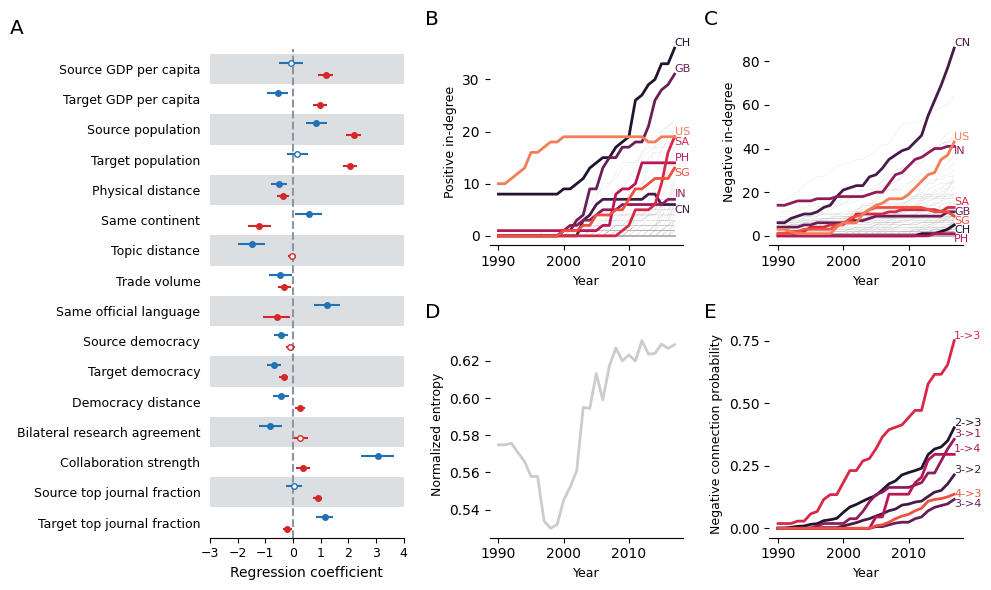

In [73]:
countries2highlight = sorted(['US', 'CH', 'GB', 'PH', 'SA', 'SG', 'CN', 'IN'])

lblsize = 9

layout = [
    ["A", "B", "C"],
    ["A", "D", "E"]
]

fig, axd = plt.subplot_mosaic(layout, figsize=(10,6))

logistic_coefficient_plot(df1, df2, ax=axd["A"])

label = "A"
trans = mtransforms.ScaledTranslation(-2, 7/72, fig.dpi_scale_trans)
axd[label].text(0.0, 1.0, label, transform=axd[label].transAxes + trans,
                   fontsize='x-large', va='center')

comm2color = {0:"#257BA0", 1:"#6AB8AB", 2:"#D65451", 3:"#FFE000", 4:"#FF9400"}

for c in countryprod['Country'].unique():
    countrysub = countryprod[countryprod['Country'] == c].sort_values('Year')
    
    if c in countries2highlight:
        color = sns.color_palette("rocket", n_colors=len(countries2highlight) + 2)[countries2highlight.index(c)]
        axd["B"].plot(countrysub['Year'].values, countrysub['PositiveInDegree'].values, color=color, lw=2, zorder=10)
        axd["C"].plot(countrysub['Year'].values, countrysub['NegativeInDegree'].values, color=color, lw=2, zorder=10)
        
        if c in ['CN', 'SA', 'SG']:
            axd["B"].text(s=c, x=countrysub['Year'].values[-1], y=countrysub['PositiveInDegree'].values[-1],
                    ha='left', va='top', color=color, fontsize=8)
        else:
            axd["B"].text(s=c, x=countrysub['Year'].values[-1], y=countrysub['PositiveInDegree'].values[-1],
                    ha='left', va='bottom', color=color, fontsize=8)
        
        if c in ['IN', 'PH', 'CH', 'SG']:
            axd["C"].text(s=c, x=countrysub['Year'].values[-1], y=countrysub['NegativeInDegree'].values[-1],
                    ha='left', va='top', color=color, fontsize=8)
        elif c in ['GB']:
            axd["C"].text(s=c, x=countrysub['Year'].values[-1], y=countrysub['NegativeInDegree'].values[-1],
                    ha='left', va='center', color=color, fontsize=8)
        else:
            axd["C"].text(s=c, x=countrysub['Year'].values[-1], y=countrysub['NegativeInDegree'].values[-1],
                    ha='left', va='bottom', color=color, fontsize=8)
    else:    
        axd["B"].plot(countrysub['Year'].values, countrysub['PositiveInDegree'].values, color='0.7', lw=0.1, zorder=1)
        axd["C"].plot(countrysub['Year'].values, countrysub['NegativeInDegree'].values, color='0.7', lw=0.1, zorder=1)

axd["B"].set_ylabel('Positive in-degree', fontsize=lblsize)
axd["C"].set_ylabel('Negative in-degree', fontsize=lblsize)
axd["D"].set_ylabel('Normalized entropy', fontsize=lblsize)
axd["E"].set_ylabel('Negative connection probability', fontsize=lblsize)

#axd["E"].axis('off')

axd['D'].plot(np.arange(1990, 2018), ygini, color='0.8', lw=2)

for i,(ic,jc) in enumerate([(1,2), (2,1), (2,3),  (2,0),(0,3), (0,2), (3,2)]):
    color=sns.color_palette("rocket", n_colors=len(countries2highlight) + 2)[i]
    axd["E"].plot(np.arange(1990, 2018), nblock_matrix[:,ic,jc], lw=2, color=color)
    
    if (ic,jc) in [(3,0),  (2,3)]:
        va = 'top'
    elif (ic,jc) in [(3,2), (3,0)]:
        va = 'center'
    else:
        va = 'bottom'
    axd["E"].text(s=str(ic+1)+"->"+str(jc+1), x=2017, y=nblock_matrix[-1,ic,jc], ha='left', va=va, 
                  color=color, fontsize=8)

#axd["E"].set_yticks([0, 0.25, 0.5,0.75])
axd["E"].set_yticks([0, 0.25, 0.5,0.75])


for label in ['B', "C", "D", "E"]:
    axd[label].set_xlabel('Year', fontsize=lblsize)
    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(-0.65, 7/72, fig.dpi_scale_trans)
    axd[label].text(0.0, 1.0, label, transform=axd[label].transAxes + trans,
                   fontsize='x-large', va='bottom')#, xx-small, x-small, small, medium, large, x-large, xx-large, larger, smaller
plt.tight_layout()

plt.savefig('Figures/Fig2_networkfeatures.pdf')

plt.show()

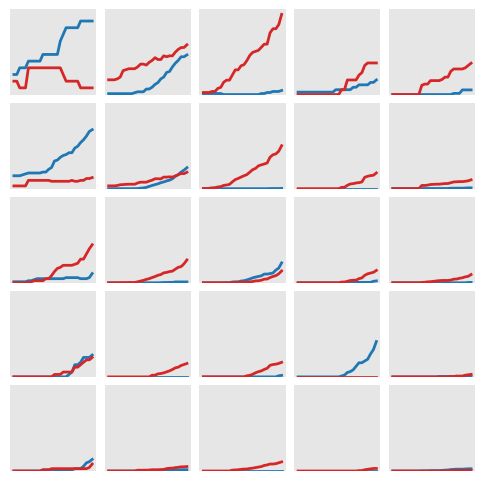

In [34]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize = (6,6))
gs = gridspec.GridSpec(nc,nc)
gs.update(wspace=0.1, hspace=0.1) # set the spacing between axes. 

fontProperties = {'family':'sans-serif','sans-serif':['Helvetica'],
    'weight' : 'normal', 'size' : 12}

for ic in fullcnames:
    for jc in fullcnames:
        
        ax = plt.subplot(gs[ic * nc + jc])
        
        #pyears = pblock_matrix[:,ic,jc] > 0
        #nyears = nblock_matrix[:,ic,jc] > 0
        
        #ax.plot(np.arange(1990, 2018)[pyears], pblock_matrix[:,ic,jc][pyears], lw=2)
        #ax.plot(np.arange(1990, 2018)[nyears], nblock_matrix[:,ic,jc][nyears], lw=2, color=sns.color_palette()[3])
        
        ax.plot(np.arange(1990, 2018), pblock_matrix[:,ic,jc], lw=2)
        ax.plot(np.arange(1990, 2018), nblock_matrix[:,ic,jc], lw=2, color=sns.color_palette()[3])
        
        ax.set_ylim([0, 0.8])
        ax.set_yticks([0,0.75])
        
        ax.tick_params(axis='y', which='major', labelsize=10)
        for tick in ax.get_yticklabels():
            tick.set_fontname("Helvetica") #"Comic Sans MS")
        
        for tick in ax.get_xticklabels():
            tick.set_fontname("Helvetica")
            tick.set_rotation(45)

        #if ~(ic == 0 and jc ==2 or ic==2 and jc ==0):
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        
        ax.set_facecolor('0.9')
        
        if jc > -1:
            ax.set_yticks([])
        
        if ic <6:
            ax.set_xticks([])
#plt.tight_layout()  

plt.savefig("Figures/CommunityInteraction_12_23.pdf", bbox_inches='tight')

plt.show()

In [25]:
def line_stick_auc(ax, auc_data, countries_to_highlight):
    ax.axhline(y=0.6, ls='-', color='0.8', lw=0.5, zorder=1)
    #ax.axhline(y=0.55, ls='-', color='0.8', lw=0.5, zorder=1)
    #ax.axhline(y=0.65, ls='-', color='0.8', lw=0.5, zorder=1)
    ax.axhline(y=0.7, ls='-', color='0.8', lw=0.5, zorder=1)
    ax.axhline(y=0.8, ls='-', color='0.8', lw=0.5, zorder=1)
    
    auc_data = auc_data.sort_values(by='AUC')
    
    for i, (auc, cname) in enumerate(auc_data[['AUC', 'Country']].values):
        if cname in countries_to_highlight:
            ax.plot([i,i], [0.5,auc], color = 'k')
            ax.scatter(i,auc, color='k')
        else:
            ax.plot([i,i], [0.5,auc], color = '0.6')
            ax.scatter(i,auc, color='0.6')
    
    ax.set_xlim([-0.5, auc_data['Country'].nunique()])
    
    ax.set_xticks(np.arange(auc_data['Country'].nunique()))
    ax.set_xticklabels(auc_data['Country'].values, 
                       rotation=45, ha='center', color='0.6', fontsize=8)
    for i in np.where(pyscisci.isin_sorted(auc_data['Country'].values, np.sort(countries_to_highlight)))[0]:
        ax.get_xticklabels()[i].set_color("k")

    ax.set_ylim([0.5, 0.82])
    
    ax.set_yticks([0.5, 0.6, 0.7, 0.8])
    ax.tick_params(axis='y', size=0)
    #ax.set_ylabel('Over-representation')
    for s in ['top', 'right', 'left']:
        ax.spines[s].set_visible(False)
    
    return ax

def mycoefplot(ax, sumdf, fontsize=10, ms=50):
    exog_vars = sumdf.index
    i=len(exog_vars) -1
    for f in exog_vars:
        if f in exog_vars:
            coeff, stderr, pvalue, lower, upper = sumdf.loc[f][['Parameter', 'Std. Err.','P-value', 'Lower CI', 'Upper CI']]
            
            #color = sns.color_palette()[1]
            color = sns.color_palette("rocket", n_colors = 4)[1]
            if pvalue >= 0.05:
                fc = 'w'
            else:
                fc = color

            ax.plot([lower, upper], [i]*2, color=color, lw=2, zorder=5)
            ax.scatter(coeff, i, s=ms, color=fc, edgecolors = color, zorder=10)
            
            if False:
                ax.text(1.9, i, "(S.E.={},P={})".format(np.round(stderr, 2), np.round(pvalue, 2)), fontsize=14, va='center')
            i-=1

    ax.grid(axis='x')
    ax.axvline(x=0, lw=2, color='k')
    ax.set_xlim([-2.5, 1.5])
    ax.set_xticks([-2,-1,0,1])
    ax.set_xlabel('Model coefficient', fontsize=fontsize)
    ax.set_ylim([-1, len(exog_vars)])

    ax.set_yticks(list(range(len(exog_vars))))

    if True:
        ax.set_yticklabels([namedict.get(fname, fname) for fname in exog_vars[::-1]], 
                             fontdict = {'rotation':0, 'horizontalalignment':'right',
                                        'fontsize':fontsize})    

    ax.tick_params(axis='x', which='major', labelsize=fontsize)
    
    return ax

In [83]:
self_auc = country_auc_df[country_auc_df['CitingCountry'] == country_auc_df['CitedCountry']].sort_values(by=['CitedYear', 'CitedCountry']).reset_index(drop=True)
self_auc = self_auc[self_auc['Significant']]
self_auc.rename(columns={'CitedYear':'Year', 'CitedCountry':'Country'}, inplace=True)

countryprod = pd.read_csv('CountryData/CountryTopProductivity.csv')
countryprod['NumPub'] = np.log10(countryprod['NumPub'])

self_auc = self_auc.merge(countryprod, how='left', on=['Country', 'Year'])

oasize = pd.read_csv('CountryData/globaltopjournal.csv')
self_auc = self_auc.merge(oasize, how='left', on='Year')
#patents = pd.read_csv('/Users/hgt6rn/Downloads/resulttable.csv', sep=';')
#patents = patents.rename(columns={'appln_filing_year':'Year', 'person_ctry_code':'Country'})

#self_auc = self_auc.merge(patents, how='left', on=['Year', 'Country'])

self_auc['NormedTop'] = self_auc['FracTop'].values/self_auc['OAFracTop'].values

national_authorship_rate = pd.read_csv( "CountryData/oa_national_authorship_rate.csv.gz")
self_auc = self_auc.merge(national_authorship_rate, how='left', on=['Country', 'Year'])

pubtopics1_div = pd.read_csv("CountryData/oa_country_topic1_diversity.csv.gz")
self_auc = self_auc.merge(pubtopics1_div, how='left', on=['Country', 'Year'])
self_auc.rename(columns={'TopicDiversity':'TopicDiversity1'}, inplace=True)
self_auc['TopicDiversity1'] = 1 - self_auc['TopicDiversity1']

pubtopics2_div = pd.read_csv("CountryData/oa_country_topic2_diversity.csv.gz")
self_auc = self_auc.merge(pubtopics2_div, how='left', on=['Country', 'Year'])
self_auc.rename(columns={'TopicDiversity':'TopicDiversity2'}, inplace=True)
self_auc['TopicDiversity2'] = 1 - self_auc['TopicDiversity2']

wbgdp = pd.read_csv('CountryData/world-bank-data.csv')
wbgdp['PAT_total'] = wbgdp['PAT_nres'] + wbgdp['PAT_res']
for c in ['GDP', 'GNI', 'GDP_PCAP', 'GNI_PCAP', 'PAT_nres', 'PAT_res', 'PAT_total', 'RND_per', 'Pop']:   #'GNI_PCAP', 'GDP_PCAP', 'RND_per'
    wbgdp[c] = np.log10(wbgdp[c].astype(float))

self_auc = self_auc.merge(wbgdp, how='left', on=['Country', 'Year'])


In [100]:
namedict['AUC'] = 'National self-preference'

effect_vars = ['Country', 'Year']
exog_vars = ['Pop', 'GDP_PCAP', "NumPub", 'RND_per', "FractionNationalAuthors", "AUC"]
dep_var = "NormedTop"

self_panel = self_auc[effect_vars + exog_vars + [dep_var]].dropna().reset_index(drop=True)
self_panel = self_panel[self_panel['Year'] >= 1990]
for c in exog_vars + [dep_var]:
    self_panel[c] = (self_panel[c] - self_panel[c].mean())/self_panel[c].std()

self_panel=self_panel.set_index(effect_vars)

#exog = sm.add_constant(self_panel[exog_vars])
mod = PanelOLS(self_panel[dep_var], self_panel[exog_vars], entity_effects=True, time_effects=True)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res)

results_as_html = res.summary.tables[1].as_html()
sumdf_topfrac = pd.read_html(results_as_html, header=0, index_col=0)[0]

exog_var_sets = [['Pop', 'GDP_PCAP'], ["NumPub", 'RND_per'], ['FractionNationalAuthors'], ['AUC']]
dep_var = "NormedTop"

make_latex_table(data=self_auc, effect_vars = effect_vars, use_const = False,
                 exog_var_sets = exog_var_sets, dep_var = dep_var, namedict = namedict)    

                          PanelOLS Estimation Summary                           
Dep. Variable:              NormedTop   R-squared:                        0.3916
Estimator:                   PanelOLS   R-squared (Between):             -0.0015
No. Observations:                 805   R-squared (Within):               0.3782
Date:                Thu, Jan 25 2024   R-squared (Overall):              0.1185
Time:                        12:50:56   Log-likelihood                    104.92
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      76.171
Entities:                          68   P-value                           0.0000
Avg Obs:                       11.838   Distribution:                   F(6,710)
Min Obs:                       1.0000                                           
Max Obs:                       22.000   F-statistic (robust):             11.138
                            

'\\begin{table}[!htb] \\centering \n    \\small\n  \\caption{\\textbf{National self-preference.}\n  Model coefficients labeled by $p$-value. Standard errors in parentheses.}  \n  \\label{table:} \n  \\begin{tabular}{lllll}\\\\[-1.8ex]\\hline \n\\hline \\\\[-1.8ex] \n\\multicolumn{5}{c}{\\textbf{Dependent variable: Fraction of publications in top venues.}} \\\\[0.8ex]\\hline \n & \\multicolumn{4}{c}{Model}  \\\\ \\cline{2-5} \\\\[-1.8ex] & (1)& (2)& (3)& (4) \\\\ \\hline \\\\[-1.8ex] \nPopulation & $-1.41$ & $0.55$ & $-0.38$ & $-0.53$\\\\ \n & $(-3.13,0.3)$ & $(-1.36,2.46)$ & $(-1.65,0.88)$ & $(-1.76,0.7)$\\\\ \n & S.E. $0.88$ p=$0.1068$ & S.E. $0.97$ p=$0.5726$ & S.E. $0.64$ p=$0.5536$ & S.E. $0.63$ p=$0.3954$\\\\ [0.8ex]  \nGDP per capita & $-0.61^{**}$ & $0.19$ & $0.68$ & $0.44$\\\\ \n & $(-1.18,-0.03)$ & $(-1.08,1.46)$ & $(-0.34,1.7)$ & $(-0.25,1.12)$\\\\ \n & S.E. $0.29$ p=$0.038$ & S.E. $0.65$ p=$0.7655$ & S.E. $0.52$ p=$0.1911$ & S.E. $0.35$ p=$0.2121$\\\\ [0.8ex]  \nNumber of pu

In [101]:

effect_vars = ['Country', 'Year']
exog_vars = ['Pop', 'GDP_PCAP', "NumPub", 'RND_per',  "FractionNationalAuthors", "AUC"]
dep_var = "TopicDiversity2"

self_panel = self_auc[effect_vars + exog_vars + [dep_var]].dropna().reset_index(drop=True)
self_panel = self_panel[self_panel['Year'] >= 1990]

for c in exog_vars + [dep_var]:
    self_panel[c] = (self_panel[c] - self_panel[c].mean())/self_panel[c].std()
    
self_panel=self_panel.set_index(effect_vars)

#exog = sm.add_constant(self_panel[exog_vars])
mod = PanelOLS(self_panel[dep_var], self_panel[exog_vars], entity_effects=True, time_effects=True)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res)

results_as_html = res.summary.tables[1].as_html()
sumdf_div = pd.read_html(results_as_html, header=0, index_col=0)[0]

make_latex_table(data=self_auc, effect_vars = effect_vars, use_const = False,
                 exog_var_sets = exog_var_sets, dep_var = dep_var, namedict = namedict)    

                          PanelOLS Estimation Summary                           
Dep. Variable:        TopicDiversity2   R-squared:                        0.1860
Estimator:                   PanelOLS   R-squared (Between):             -0.1184
No. Observations:                 805   R-squared (Within):              -0.8011
Date:                Thu, Jan 25 2024   R-squared (Overall):             -1.1839
Time:                        12:51:00   Log-likelihood                    360.98
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      27.042
Entities:                          68   P-value                           0.0000
Avg Obs:                       11.838   Distribution:                   F(6,710)
Min Obs:                       1.0000                                           
Max Obs:                       22.000   F-statistic (robust):             4.0934
                            

'\\begin{table}[!htb] \\centering \n    \\small\n  \\caption{\\textbf{National self-preference.}\n  Model coefficients labeled by $p$-value. Standard errors in parentheses.}  \n  \\label{table:} \n  \\begin{tabular}{lllll}\\\\[-1.8ex]\\hline \n\\hline \\\\[-1.8ex] \n\\multicolumn{5}{c}{\\textbf{Dependent variable: Fraction of publications in top venues.}} \\\\[0.8ex]\\hline \n & \\multicolumn{4}{c}{Model}  \\\\ \\cline{2-5} \\\\[-1.8ex] & (1)& (2)& (3)& (4) \\\\ \\hline \\\\[-1.8ex] \nPopulation & $-0.7$ & $-1.62^{*}$ & $-1.39^{*}$ & $-1.26$\\\\ \n & $(-1.76,0.37)$ & $(-3.32,0.08)$ & $(-3.03,0.25)$ & $(-2.86,0.35)$\\\\ \n & S.E. $0.54$ p=$0.1987$ & S.E. $0.87$ p=$0.0625$ & S.E. $0.84$ p=$0.0973$ & S.E. $0.82$ p=$0.1241$\\\\ [0.8ex]  \nGDP per capita & $0.06$ & $-0.21$ & $-0.33$ & $-0.12$\\\\ \n & $(-0.43,0.55)$ & $(-0.91,0.5)$ & $(-1.01,0.35)$ & $(-0.62,0.39)$\\\\ \n & S.E. $0.25$ p=$0.8087$ & S.E. $0.36$ p=$0.5677$ & S.E. $0.35$ p=$0.3447$ & S.E. $0.26$ p=$0.6492$\\\\ [0.8ex]  \nNumbe

In [105]:

effect_vars = ['Country', 'Year']
exog_vars = ['Pop', 'GDP_PCAP', "NumPub", 'RND_per',  "FractionNationalAuthors", "AUC"]
dep_var = "PAT_res"

self_panel = self_auc[effect_vars + exog_vars + [dep_var]].dropna().reset_index(drop=True)
self_panel = self_panel[self_panel['Year'] >= 1990]

for c in exog_vars + [dep_var]:
    self_panel[c] = (self_panel[c] - self_panel[c].mean())/self_panel[c].std()
    
self_panel=self_panel.set_index(effect_vars)

#exog = sm.add_constant(self_panel[exog_vars])
mod = PanelOLS(self_panel[dep_var], self_panel[exog_vars], entity_effects=True, time_effects=True)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res)

results_as_html = res.summary.tables[1].as_html()
sumdf_pat = pd.read_html(results_as_html, header=0, index_col=0)[0]

make_latex_table(data=self_auc, effect_vars = effect_vars, use_const = False,
                 exog_var_sets = exog_var_sets, dep_var = dep_var, namedict = namedict)    

                          PanelOLS Estimation Summary                           
Dep. Variable:                PAT_res   R-squared:                        0.5953
Estimator:                   PanelOLS   R-squared (Between):              0.6455
No. Observations:                 766   R-squared (Within):               0.2194
Date:                Thu, Jan 25 2024   R-squared (Overall):              0.5636
Time:                        13:41:36   Log-likelihood                    504.08
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      165.46
Entities:                          64   P-value                           0.0000
Avg Obs:                       11.969   Distribution:                   F(6,675)
Min Obs:                       1.0000                                           
Max Obs:                       22.000   F-statistic (robust):             21.158
                            

'\\begin{table}[!htb] \\centering \n    \\small\n  \\caption{\\textbf{National self-preference.}\n  Model coefficients labeled by $p$-value. Standard errors in parentheses.}  \n  \\label{table:} \n  \\begin{tabular}{lllll}\\\\[-1.8ex]\\hline \n\\hline \\\\[-1.8ex] \n\\multicolumn{5}{c}{\\textbf{Dependent variable: Fraction of publications in top venues.}} \\\\[0.8ex]\\hline \n & \\multicolumn{4}{c}{Model}  \\\\ \\cline{2-5} \\\\[-1.8ex] & (1)& (2)& (3)& (4) \\\\ \\hline \\\\[-1.8ex] \nPopulation & $1.29^{*}$ & $0.11$ & $0.22$ & $0.16$\\\\ \n & $(-0.16,2.74)$ & $(-1.35,1.57)$ & $(-1.32,1.76)$ & $(-1.41,1.72)$\\\\ \n & S.E. $0.74$ p=$0.0821$ & S.E. $0.74$ p=$0.8811$ & S.E. $0.78$ p=$0.7819$ & S.E. $0.8$ p=$0.8428$\\\\ [0.8ex]  \nGDP per capita & $1.33^{***}$ & $0.76^{***}$ & $0.71^{**}$ & $0.59^{**}$\\\\ \n & $(0.89,1.77)$ & $(0.25,1.27)$ & $(0.13,1.29)$ & $(0.14,1.04)$\\\\ \n & S.E. $0.22$ p=$0.0$ & S.E. $0.26$ p=$0.0034$ & S.E. $0.3$ p=$0.0166$ & S.E. $0.23$ p=$0.0102$\\\\ [0.8ex]  \nN

In [106]:

effect_vars = ['Country', 'Year']
exog_vars = ['Pop', 'GDP_PCAP', "NumPub", 'RND_per',  "FractionNationalAuthors", "AUC"]
dep_var = "PAT_total"

self_panel = self_auc[effect_vars + exog_vars + [dep_var]].dropna().reset_index(drop=True)
self_panel = self_panel[self_panel['Year'] >= 1990]

for c in exog_vars + [dep_var]:
    self_panel[c] = (self_panel[c] - self_panel[c].mean())/self_panel[c].std()
    
self_panel=self_panel.set_index(effect_vars)

#exog = sm.add_constant(self_panel[exog_vars])
mod = PanelOLS(self_panel[dep_var], self_panel[exog_vars], entity_effects=True, time_effects=True)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res)

results_as_html = res.summary.tables[1].as_html()
sumdf_pattot = pd.read_html(results_as_html, header=0, index_col=0)[0]

make_latex_table(data=self_auc, effect_vars = effect_vars, use_const = False,
                 exog_var_sets = exog_var_sets, dep_var = dep_var, namedict = namedict)    

                          PanelOLS Estimation Summary                           
Dep. Variable:              PAT_total   R-squared:                        0.4488
Estimator:                   PanelOLS   R-squared (Between):              0.1157
No. Observations:                 765   R-squared (Within):               0.1909
Date:                Thu, Jan 25 2024   R-squared (Overall):             -0.3219
Time:                        13:41:36   Log-likelihood                    444.40
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      91.448
Entities:                          64   P-value                           0.0000
Avg Obs:                       11.953   Distribution:                   F(6,674)
Min Obs:                       1.0000                                           
Max Obs:                       22.000   F-statistic (robust):             13.163
                            

'\\begin{table}[!htb] \\centering \n    \\small\n  \\caption{\\textbf{National self-preference.}\n  Model coefficients labeled by $p$-value. Standard errors in parentheses.}  \n  \\label{table:} \n  \\begin{tabular}{lllll}\\\\[-1.8ex]\\hline \n\\hline \\\\[-1.8ex] \n\\multicolumn{5}{c}{\\textbf{Dependent variable: Fraction of publications in top venues.}} \\\\[0.8ex]\\hline \n & \\multicolumn{4}{c}{Model}  \\\\ \\cline{2-5} \\\\[-1.8ex] & (1)& (2)& (3)& (4) \\\\ \\hline \\\\[-1.8ex] \nPopulation & $1.12$ & $-0.11$ & $-0.03$ & $-0.1$\\\\ \n & $(-0.33,2.57)$ & $(-1.5,1.28)$ & $(-1.4,1.34)$ & $(-1.48,1.28)$\\\\ \n & S.E. $0.74$ p=$0.1304$ & S.E. $0.71$ p=$0.8751$ & S.E. $0.7$ p=$0.9678$ & S.E. $0.7$ p=$0.8868$\\\\ [0.8ex]  \nGDP per capita & $1.18^{***}$ & $0.88^{***}$ & $0.84^{***}$ & $0.75^{***}$\\\\ \n & $(0.64,1.72)$ & $(0.33,1.43)$ & $(0.26,1.43)$ & $(0.24,1.26)$\\\\ \n & S.E. $0.27$ p=$0.0$ & S.E. $0.28$ p=$0.0017$ & S.E. $0.3$ p=$0.0049$ & S.E. $0.26$ p=$0.0041$\\\\ [0.8ex]  \nNumb

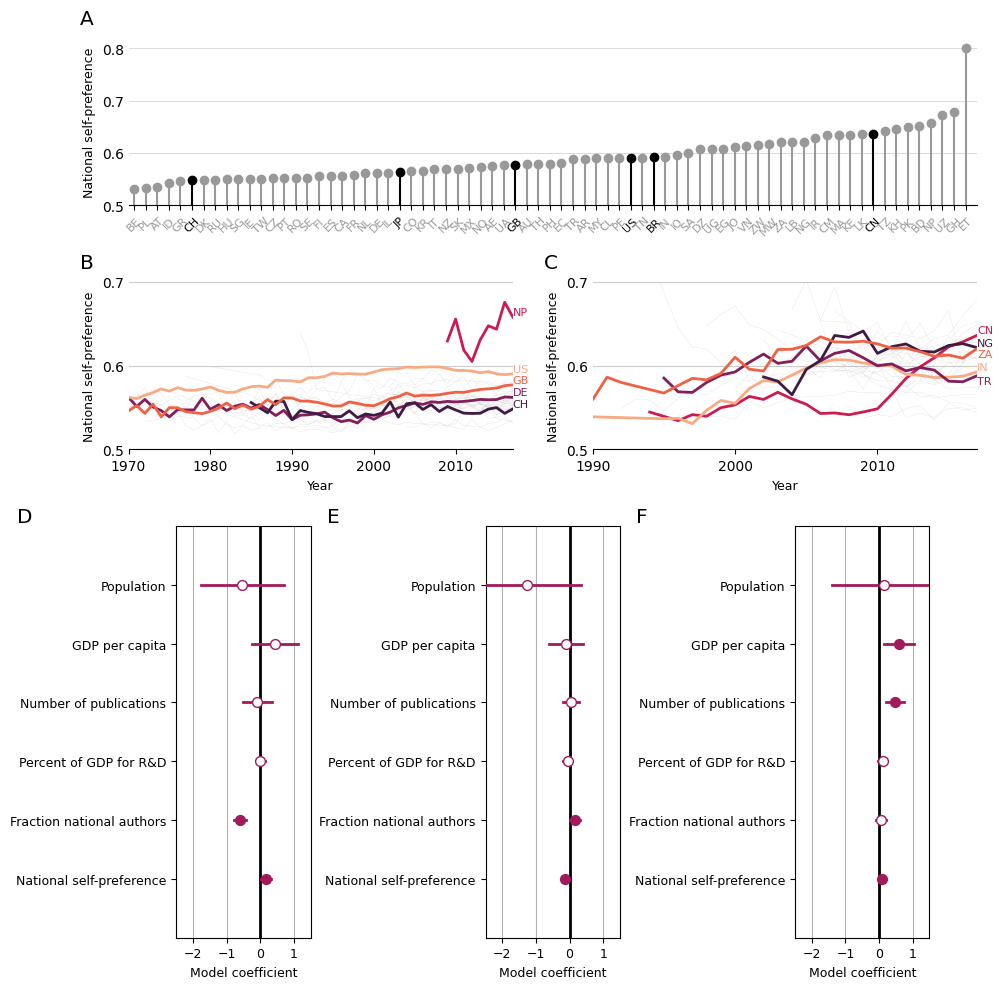

In [107]:


layout = [
    ["A", "A", "A", "A", "A", "A"],
    [ "B", "B", "B", "C","C","C"],
    [ "D", "D", 'E','E','F', 'F'],
    [ "D", "D", 'E','E', 'F', 'F']
]

fig, axd = plt.subplot_mosaic(layout, figsize=(10,10))


self_auc2017 = self_auc[self_auc['Year'] == 2017]
line_stick_auc(axd["A"], self_auc2017, ['US', 'CN', 'JP', 'CH', 'GB', 'BR'])

countries2highlight = sorted(['US', 'CH', 'GB', 'DE', 'CN', 'IN', 'NP', 'ZA', 'TR', 'NG'])

#for i,c in enumerate(['GB', 'JP', 'CN', 'CH', 'US']):
for iax, countrylist in zip(["B", "C", "D"], [comm2country[2] + comm2country[3], comm2country[0] + comm2country[4]]):
    subcountries2highlight = list(set(countries2highlight).intersection(set(countrylist)))
    for c in countrylist:
        selfcountry = self_auc[self_auc['Country'] == c]
        selfcountry = selfcountry[selfcountry['Significant']]
        selfcountry = selfcountry[selfcountry['Year'] >= 1970]
        if selfcountry.shape[0] > 2 and c!= 'ET':
            #print(c, selfcountry['AUC'].max())
            if c in countries2highlight:
                color = sns.color_palette("rocket", n_colors = len(subcountries2highlight))[subcountries2highlight.index(c)]
                axd[iax].plot(selfcountry['Year'].values, selfcountry['AUC'].values, color=color, lw=2, zorder=10)

                if c in ['ZA', 'TR']:
                    axd[iax].text(s=c, x=selfcountry['Year'].values[-1], y=selfcountry['AUC'].values[-1],
                            ha='left', va='top', color=color, fontsize=8)
                else:
                    axd[iax].text(s=c, x=selfcountry['Year'].values[-1], y=selfcountry['AUC'].values[-1],
                            ha='left', va='bottom', color=color, fontsize=8)
            else:    
                axd[iax].plot(selfcountry['Year'].values, selfcountry['AUC'].values, color='0.7', lw=0.1)
        #print(c, selfcountry['CitedYear'].values[np.argmin(selfcountry['AUC'].values)], selfcountry['CitedYear'].values[np.argmax(selfcountry['AUC'].values)])

axd["A"].set_ylabel('National self-preference', fontsize=lblsize) 

for iax in ["B", "C"]:
    axd[iax].set_ylim([0.5, 0.7])
    #axd[iax].set_yticks([0.5, 0.55, 0.6, 0.65])
    axd[iax].set_yticks([0.5, 0.6, 0.7])
    axd[iax].set_xlim([1990, 2017]) 
    axd[iax].set_xticks([1990,2000,2010])

    axd[iax].set_ylabel('National self-preference', fontsize=lblsize) 
    #axd[iax].legend()
    
    axd[iax].set_xlabel('Year', fontsize=lblsize)
    
    axd[iax].grid(axis='y', which='major', color='0.8', linestyle='-')
    axd[iax].tick_params(axis='y', size=0)
    for s in ['top', 'right', 'left']:
        axd[iax].spines[s].set_visible(False)

#axd["D"].set_ylim([0.5, 0.8])

axd["B"].set_xlim([1970, 2017]) 
axd["B"].set_xticks([1970,1980,1990,2000,2010])

mycoefplot(axd["D"], sumdf_topfrac, fontsize=lblsize, ms=50)
mycoefplot(axd["E"], sumdf_div, fontsize=lblsize)
mycoefplot(axd["F"], sumdf_pat, fontsize=lblsize)


for label in ["A", "B", "C"]:
    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(-35/72, 7/72, fig.dpi_scale_trans)
    axd[label].text(0.0, 1.0, label, transform=axd[label].transAxes + trans,
                   fontsize='x-large', va='bottom')#, xx-small, x-small, small, medium, large, x-large, xx-large, larger, smaller

for label in ["D", "E", 'F']:
    axd[label].set_aspect(1.75)
    trans = mtransforms.ScaledTranslation(-1.59, 7/72, fig.dpi_scale_trans)
    axd[label].text(0.0, 1.0, label, transform=axd[label].transAxes + trans,
                   fontsize='x-large', va='center')
#axd["F"].axis('off')
#axd["G"].axis('off')

plt.tight_layout()

plt.savefig("Figures/fig3.pdf", bbox_inches='tight')
plt.show()

In [ ]:
comm2country = {0:['AE', 'BD', 'CN', 'CY', 'DZ', 'EG', 'ID', 'IN', 'IQ', 'IR', 'JO', 'KH', 'KR', 'KW', 'MA', 'MY', 'OM', 'PK', 'QA', 'SA', 'SG', 'TH', 'TN', 'TR', 'TW', 'VN'],
1:['AR', 'BN', 'BO', 'BR', 'BW', 'BY', 'CL', 'CM', 'CO', 'CR', 'GE', 'HK', 'HR', 'LU', 'MZ', 'NC', 'PA', 'PE', 'RU', 'SJ', 'ST', 'UY', 'VE'],
2:['AT', 'BE', 'CA', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'GR', 'HU', 'IE', 'IL', 'IS', 'IT', 'JP', 'MX', 'NL', 'NO', 'NP', 'NZ', 'PH', 'PL', 'PT', 'RO', 'SE', 'SI', 'SK'],
3:['AU', 'CH', 'GB', 'US'],
4:['BH', 'ET', 'GH', 'KE', 'MW', 'NG', 'TZ', 'UG', 'ZA', 'ZM', 'ZW']}

In [44]:
print(axd["D"].get_aspect())


plt.show()

auto


In [99]:
pyscisci.simpson([0,1,2,3,4,5,6]), pyscisci.simpson([0,0,0,0,0,0,1])

(0.14285714285714285, 0.7551020408163265)

In [75]:

def pvalue2stars(pvalue):
    if pvalue < 0.01:
        return "^{***}"
    elif pvalue < 0.05:
        return "^{**}"
    elif pvalue < 0.1:
        return "^{*}"
    else:
        return ""
    
def table_row(varname='const', offset=0, roun=2, modellist=[], namedict={}):
    row_text = namedict[varname] + " & "*(offset+1) + " & ".join([ "$" + str(model.params[varname].round(roun)) + pvalue2stars(model.pvalues[varname]) + "$" for model in modellist[offset:]]) + "\\\\ \n"
    row_text +=  " & "*(offset+1) + " & ".join([ "$(" + str(model.conf_int().loc[varname]['lower'].round(roun)) + "," + str(model.conf_int().loc[varname]['upper'].round(roun)) + ")$" for model in modellist[offset:]]) + "\\\\ \n"
    row_text +=  " & "*(offset+1) + " & ".join([ "S.E. $" + str(model.std_errors[varname].round(roun)) + "$ p=$" + str(model.pvalues[varname].round(4)) + "$" for model in modellist[offset:]]) + "\\\\ [0.8ex]  \n"
    return row_text

def make_latex_table(data, effect_vars = [], exog_var_sets = [], dep_var = "", use_const = False, 
                     normvar = True, namedict = {}, caption_text=""):
    
    Nmodels = len(exog_var_sets)
    
    fit_models = []
    for icol in range(Nmodels):
        exog_vars = list(chain.from_iterable(exog_var_sets[:(icol+1)]))
        self_panel = data[effect_vars + exog_vars + [dep_var]].dropna().reset_index(drop=True)
        if normvar:
            for c in exog_vars + [dep_var]:
                self_panel[c] = (self_panel[c] - self_panel[c].mean())/self_panel[c].std()
                
        self_panel=self_panel.set_index(effect_vars)
        if use_const:
            exog = sm.add_constant(self_panel[exog_vars])
        else:
            exog = self_panel[exog_vars]
        mod = PanelOLS(self_panel[dep_var], self_panel[exog_vars], entity_effects=True, time_effects=True)
        fit_models.append(mod.fit(cov_type='clustered', cluster_entity=True))
    
    
    table_text = """\\begin{table}[!htb] \\centering 
    \\small
  \\caption{\\textbf{National self-preference.}
  Model coefficients labeled by $p$-value. Standard errors in parentheses.}  
  \\label{table:} 
  \\begin{tabular}{l""" + "l"*Nmodels + "}"
    
    table_text += """\\\\[-1.8ex]\\hline 
\\hline \\\\[-1.8ex] 
\\multicolumn{""" + str(Nmodels+1) + """}{c}{\\textbf{Dependent variable: Fraction of publications in top venues.}} \\\\[0.8ex]\\hline 
 & \\multicolumn{""" + str(Nmodels) + """}{c}{Model}  \\\\ """
    
    table_text += "\cline{2-" + str(Nmodels + 1) + "} \\\\[-1.8ex] "
    
    for icol in range(Nmodels):
        table_text += "& (" + str(icol + 1) + ")"
    
    table_text += " \\\\ \hline \\\\[-1.8ex] \n"
    
    # add constant
    if use_const:
        table_text += table_row(varname='const', offset=0, roun=2, modellist=fit_models, namedict=namedict)
    
    for offset, varlist in enumerate(exog_var_sets):
        for var in varlist:
            table_text += table_row(varname=var, offset=offset, roun=2, modellist=fit_models, namedict=namedict)
    
    table_text += """\\hline 
\\hline \\\\[-1.8ex] 
\\textit{Note:} & \\multicolumn{2}{r}{$^{*}p<0.05$; $^{**}p<0.01$; $^{***}p<0.001$} \\\\ \n"""
    
    table_text += "Observations & " + " & ".join([str(model.nobs) for model in fit_models]) + " \\\\ \n"
    table_text += "$R^2$ & " + " & ".join([str(np.round(model.rsquared, 4)) for model in fit_models]) + " \\\\ \n"
    table_text += "Log Likelihood & " + " & ".join([str(model.loglik.round(2)) for model in fit_models]) + " \\\\ \n"
    table_text += "F statistic & " + " & ".join(["$" + str(np.round(model.f_statistic.stat, 2)) + pvalue2stars(model.f_statistic.pval) + "$ (d.f.=" + str(model.f_statistic.df) + ")" for model in fit_models]) + " \\\\ \n"
    table_text += "\\hline \n\\end{tabular} \n\\end{table}"
    
    print(table_text)
    return table_text
    


In [128]:
positive_net = net_auc[net_auc['CitedYear'] <= 2017].drop_duplicates(subset=['CitingCountry', 'CitedCountry'], keep='last')

positive_net['Sign'] = positive_net['Zscore'] > 0

In [134]:
from sklearn.neighbors import KernelDensity

def make_kde(x, x_d=np.linspace(0, 1, 1000), bandwidth=0.01, color='k', alpha=0.5, ax=None):
    kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
    kde.fit(x[:, None])

    # score_samples returns the log of the probability density
    logprob = kde.score_samples(x_d[:, None])

    ax.fill_between(x_d, np.exp(logprob), alpha=alpha, color=color)
    return ax

def micro_weak_balance(g):
    node_bal = {}
    for a in g.nodes():
        node_bal[a] = [0,0]
        suc = set([s for s in g.successors(a)])
        for b in suc:
            for c in g.successors(b):
                if c in suc:
                    if sum([g[a][b]['sign'], g[b][c]['sign'], g[a][c]['sign']]) == 2:
                        node_bal[a][1] += 1
                    else:
                        node_bal[a][0] += 1
                        
    return node_bal


def micro_strong_balance(g):
    
    good_set = set([0,2])
    
    node_bal = {}
    for a in g.nodes():
        node_bal[a] = [0,0]
        suc = set([s for s in g.successors(a)])
        for b in suc:
            for c in g.successors(b):
                if c in suc:
                    if sum([g[a][b]['sign'], g[b][c]['sign'], g[a][c]['sign']]) in good_set:
                        node_bal[a][1] += 1
                    else:
                        node_bal[a][0] += 1
                        
    return node_bal
  
def preserve_sign_rand_net(ndf):
    rnet = []
    for s in [False, True]:
        rsub = ndf[ndf['Sign'] == s][['CitingCountry', 'CitedCountry', 'Sign']].copy()
        rsub['CitedCountry'] = rsub['CitedCountry'].sample(frac=1).values 
        rnet.append(rsub)

    rnet = pd.concat(rnet)
    return rnet

def reverse_neg_edges(ndf):
    sub = ndf[ndf['Sign'] == False][['CitingCountry', 'CitedCountry', 'Sign']].copy()
    sub['CitedCountry'] = ndf[ndf['Sign'] == False]['CitingCountry'].values
    sub['CitingCountry'] = ndf[ndf['Sign'] == False]['CitedCountry'].values
    
    return pd.concat([ndf[ndf['Sign'] == True][['CitingCountry', 'CitedCountry', 'Sign']].copy(), sub])

In [131]:
nxnet = nx.DiGraph()
for s,t,z in positive_net[['CitingCountry', 'CitedCountry', 'Zscore']].values:
    nxnet.add_edge(s,t, sign=z>0)
node_bal = micro_weak_balance(nxnet)
bal = np.array([t[0]/sum(t) for t in node_bal.values() if sum(t) > 0]) 

tbal = np.array(list(node_bal.values())).sum(axis=0)
print(tbal.sum(), tbal)
print(tbal[0]/tbal.sum())

print(bal.mean())


nsamples= 100

rweakbal = np.zeros(nsamples)
rweakbalnodes = []
for isample in range(nsamples):
    rnet = preserve_sign_rand_net(positive_net)

    rnxnet = nx.DiGraph()
    for s,t,z in rnet[['CitingCountry', 'CitedCountry', 'Sign']].values:
        rnxnet.add_edge(s,t, sign=z>0)

    rnode_bal = micro_weak_balance(rnxnet)
    
    rweakbalnodes.extend([t[0]/sum(t) for t in rnode_bal.values() if sum(t) > 0]) 
    
    trbal = np.array(list(rnode_bal.values())).sum(axis=0)
    
    rweakbal[isample] = trbal[0]/trbal.sum()


32042 [29339  2703]
0.9156419699144872
0.943179224587388


In [153]:
print(trbal.sum(), trbal)
print(trbal[0]/trbal.sum())

#print(trbal.mean())
print((bal.mean() - np.mean(rweakbalnodes))/np.std(rweakbalnodes))

11989 [9538 2451]
0.7955625990491284
0.6204220794050506


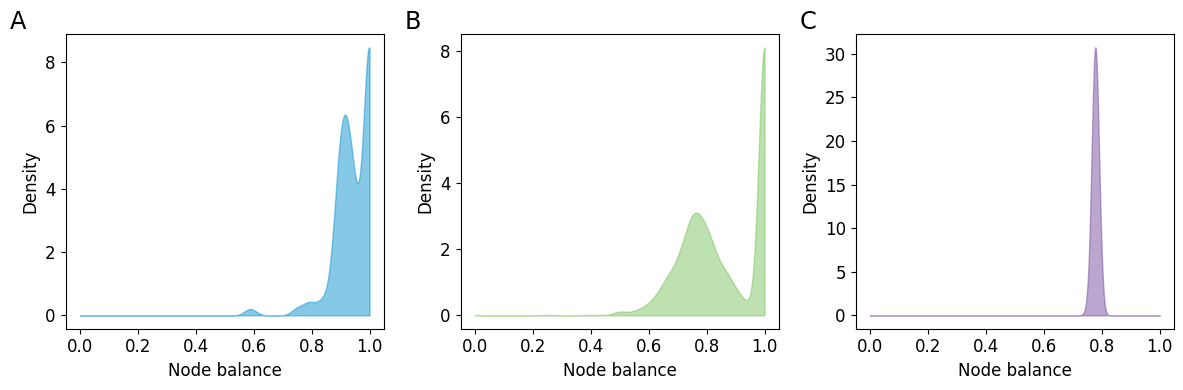

In [148]:
eurofund_palette = ['#0D95D0', '#7DC462', '#E72F52', '#774FA0', '#EFB743', '#D44627']

fig, ax = plt.subplots(1,3,figsize=(12,4))

make_kde(bal, x_d=np.linspace(0, 1, 1000), bandwidth=0.02, color=eurofund_palette[0], 
                 alpha=0.5, ax=ax[0])

make_kde(np.array(rweakbalnodes), x_d=np.linspace(0, 1, 1000), bandwidth=0.02, color=eurofund_palette[1], 
                 alpha=0.5, ax=ax[1])

make_kde(rweakbal, x_d=np.linspace(0, 1, 1000), bandwidth=0.01, color=eurofund_palette[3], 
                 alpha=0.5, ax=ax[2])


for iax in range(3):
    ax[iax].tick_params(axis='x', labelsize=12)
    ax[iax].tick_params(axis='y', labelsize=12)
    ax[iax].set_ylabel('Density', fontsize=12)
    ax[iax].set_xlabel('Node balance', fontsize=12)
    
    
for iax,label in enumerate(["A", "B", "C"]):
    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(-40/72, 0/72, fig.dpi_scale_trans)
    ax[iax].text(0.0, 1.0, label, transform=ax[iax].transAxes + trans,
                   fontsize='xx-large', va='bottom')#, xx-small, x-small, small, medium, large, x-large, xx-large, larger, smaller

plt.tight_layout()    
#ax.set_xlabel('Node balance', fontsize=20)
plt.savefig('Figures/weakbalance.pdf')
plt.show()